## Anomaly Detection in multi-dimensional Time series data
### Approach Note:
The task was to identify breakdowns of a motor given time series data of the sensors. Since, breakdown qualify as a black swan event, anaomaly detection techniques were used to identify the breakdown.

Our given target variable was 'BFPT_B_LP_SPEED_INPUT__1__'.  

We begin our task by exploring the variables by univariate analysis, fill rate analysis. By plotting their distribution we construct our definition of different modes of the motor, namely, "open", "shut", "motor_start" and "breakdown". 

For indentification of anomalies in multi-dimensional time series data we use [LSTM encoder decoder](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2015-56) and [Recurrent EBM ](http://proceedings.mlr.press/v48/zhai16.pdf)

For indentification of anomalies in multi-dimensional space (without capturing the sense of sequence) we use Isolation Forest was used for the task and verify our previous results. 

We use our constructed definition of breakdown to create a 'flag' and build a tree-based binary classifier to identification of most important sensor (feature).

We discuss the future scope and improvements at the end of the notebook


##### Importing Libraries and cloning useful git repos

In [ ]:
import os
cwd=os.getcwd()
! git clone https://github.com/ishitwaviranchi/DeepADoTS.git
os.chdir(os.path.join(os.getcwd(), "DeepADoTS/"))
!pip install -r requirements.txt  
!python3 main.py
os.chdir(cwd)

In [350]:
import pandas as pd
import plotly.express as px
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
import plotly.graph_objects as go
import const
from plotly.subplots import make_subplots
import numpy as np

import tensorflow as tf
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import IsolationForest
from DeepADoTS.src.algorithms import RecurrentEBM, LSTMAD

###### Saving name of target in separate file
from here, 'BFPT_B_LP_SPEED_INPUT__1__' would be refered as const.target

In [334]:
const.target

'BFPT_B_LP_SPEED_INPUT__1__'

###### inital look into data

In [336]:
df=pd.read_csv('baldwin_pump_data.csv')
df=pd.DataFrame(df.values, columns=['Timestamp']+list(df.columns[1:]))
df['Timestamp']=pd.to_datetime(df['Timestamp'])

In [337]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df


column_name  percent_missing
BFP_2B_IBRD_SEAL_INJ_FLOW_  BFP_2B_IBRD_SEAL_INJ_FLOW_        92.867862
BFP_2B_OBRD_SEAL_INJ_FLOW_  BFP_2B_OBRD_SEAL_INJ_FLOW_        59.481873
BFPT_2B_AXIAL_SHAFT_VIB___  BFPT_2B_AXIAL_SHAFT_VIB___        54.197931
BFPT_2B_RAD_SHAFT_VIB_OB_B  BFPT_2B_RAD_SHAFT_VIB_OB_B        51.220283
2B_BFPT_ROTOR_VIB_OBRG____  2B_BFPT_ROTOR_VIB_OBRG____        48.234737
BFP_2B_AXIAL_SHAFT_VIB____  BFP_2B_AXIAL_SHAFT_VIB____        45.233394
BFP_SUCT_HDR_PRESS________  BFP_SUCT_HDR_PRESS________        32.493484
2B_BFPT_ROTOR_VIB_IBRB____  2B_BFPT_ROTOR_VIB_IBRB____        24.634705
BFP_DSCH_HDR_PRESS________  BFP_DSCH_HDR_PRESS________        22.904984
BFP_2B_RAD_SHAFT_VIB_OB_BR  BFP_2B_RAD_SHAFT_VIB_OB_BR        19.287576
BFPT_2B_BRG_2_DRAIN_TEMP__  BFPT_2B_BRG_2_DRAIN_TEMP__        16.412606
BFPT_2B_FIRST_STAGE_PRESS_  BFPT_2B_FIRST_STAGE_PRESS_        12.384488
BFP_2B_LUBE_OIL_PRESS_____  BFP_2B_LUBE_OIL_PRESS_____         8.917147
BFP_2B_THRUST_BRG_TEMP____  BFP_2B_THRUST_BRG_TEMP____         4.873233
BFP_2B_OUT_BRG_TEMP_______  BFP_2B_OUT_BRG_TEMP_______         4.288761
BFP_2B_RAD_SHAFT_VIB_IB_BR  BFP_2B_RAD_SHAFT_VIB_IB_BR         1.421689
BFPT_2B_RAD_SHAFT_VIB_IB_B  BFPT_2B_RAD_SHAFT_VIB_IB_B         0.853013
2B_TDBFP_RECIRC_FLOW______  2B_TDBFP_RECIRC_FLOW______         0.758234
EXT_STM_FLOW_TO_BFP_2B____  EXT_STM_FLOW_TO_BFP_2B____         0.702946
BFPT_2B_THRUST_BRG_WEAR___  BFPT_2B_THRUST_BRG_WEAR___         0.679251
CW_FRM_AUX_CDSR_2B________  CW_FRM_AUX_CDSR_2B________         0.205355
BFP_2B_BAL_DRUM_FLOW______  BFP_2B_BAL_DRUM_FLOW______         0.118474
MAIN_STEAM_FLOW_TO_BFPS___  MAIN_STEAM_FLOW_TO_BFPS___         0.118474
BFP_SEAL_WATER_FLOW                BFP_SEAL_WATER_FLOW         0.118474
AUX_CDSR_2B_PRESS_________  AUX_CDSR_2B_PRESS_________         0.118474
BFP_DISCHARGE_HEADER_TEMP_  BFP_DISCHARGE_HEADER_TEMP_         0.110576
BFP_2B_BARREL_BOT_OBRD_TEM  BFP_2B_BARREL_BOT_OBRD_TEM         0.094779
BFP_2B_OBRD_SEAL_INJ_DRN_T  BFP_2B_OBRD_SEAL_INJ_DRN_T         0.094779
BFP_2B_IBRD_SEAL_INJ_DRN_T  BFP_2B_IBRD_SEAL_INJ_DRN_T         0.094779
BFPT_2B_IN_BRG_MTL_TEMP___  BFPT_2B_IN_BRG_MTL_TEMP___         0.094779
CW_TO_AUX_CDS_2B                      CW_TO_AUX_CDS_2B         0.094779
BFP_2B_BARREL_TOP_OBRD_TEM  BFP_2B_BARREL_TOP_OBRD_TEM         0.094779
2B_TDBFP_DISCHARGE_FLOW___  2B_TDBFP_DISCHARGE_FLOW___         0.094779
BFP_SUCTION_HDR_TEMP______  BFP_SUCTION_HDR_TEMP______         0.094779
BFPT_B_VALVE_DEMAND_HP_STO  BFPT_B_VALVE_DEMAND_HP_STO         0.094779
BFPT_B_VALVE_DEMAND_LP_STO  BFPT_B_VALVE_DEMAND_LP_STO         0.094779
BFPT_B_CALC_VALVE_DEMAND__  BFPT_B_CALC_VALVE_DEMAND__         0.094779
2B_TDBFP_RECIRC_VLV_DMD___  2B_TDBFP_RECIRC_VLV_DMD___         0.094779
BFP_2B_DISCHARGE_FLOW_____  BFP_2B_DISCHARGE_FLOW_____         0.094779
2B_TDBFP_RECIRC_VLV_POS___  2B_TDBFP_RECIRC_VLV_POS___         0.094779
BFP_2B_BARREL_BOT_IBRD_TEM  BFP_2B_BARREL_BOT_IBRD_TEM         0.094779
BFPT_B_LP_SPEED_INPUT__1__  BFPT_B_LP_SPEED_INPUT__1__         0.094779
BFPT_B_LP_SPEED_INPUT__2__  BFPT_B_LP_SPEED_INPUT__2__         0.094779
BFP_2B_IN_BRG_TEMP________  BFP_2B_IN_BRG_TEMP________         0.094779
BFPT_2B_BRG_1_DRAIN_TEMP__  BFPT_2B_BRG_1_DRAIN_TEMP__         0.094779
BFPT_2B_THRUST_BRG_DRAIN__  BFPT_2B_THRUST_BRG_DRAIN__         0.094779
BFP_2B_BARREL_TOP_IBRD_TEM  BFP_2B_BARREL_TOP_IBRD_TEM         0.094779
Timestamp                                    Timestamp         0.000000

###### Function to remove redundant (highly correlated columns)
Setting threshold to 90%

In [341]:
def correlation(dataset, threshold):
    corr_cols=[]
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    corr_cols.append(colname)
                    del dataset[colname] # deleting the column from the dataset

    return dataset, corr_cols

In [342]:
n_df, corr_cols=correlation(df.fillna(-1), 0.9)

###### Function to create data for candlesticks visualization 

In [339]:
def candle_group(df, col, freq='1h'):
    gr=df.groupby(pd.Grouper(key='Timestamp',freq=freq))
    high=gr[col].max()
    low=gr[col].min()
    open_=gr[col].first()
    close=gr[col].last()
    return pd.DataFrame.from_dict({
        'Timestamp':gr['Timestamp'].first() ,
        'open':open_,
        'high':high, 
        'low':low,
        'close':close
    })

###### Visualizing from interactive graphs for univariate analysis of variables
Variables are grouped on a '1 hour' (default) window for ease of visualization through candlesticks

*select variable from dropdown in*
*the slider can be used to zoom in*

In [343]:
fig=go.Figure()
for index in range(len(list(n_df.columns[1:]))):
    col=list(n_df.columns[1:])[index]
    cd=candle_group(df, col)
    gr, open_, high, low, close=[cd[x] for x in cd]
    fig.add_trace(go.Candlestick(x=gr, open=open_, high=high, low=low, close=close, name=col, \
                                 visible=False))
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list([
            dict(
                args=[{"variable": [col],"visible":[True if x==list(n_df.columns[1:]).index(col) else False for x in\
                                                    range(len(list(n_df.columns[1:]))) ],\
                      'title':col, 'showlegend':True}],
                label=col,
                method="restyle"
            )
        for col in list(n_df.columns[1:])] )
        )
    ])


##### Performing same analysis for const.target, for 3 different time window (1 day, 1 hour and 20 minutes)

In [344]:
for time in ['1d', '1h', '20min']:
    fig=go.Figure()
    col=const.target
    cd=candle_group(df.drop(df[df[const.target].isnull()==True].index, axis=0), col, time)
    gr, open_, high, low, close=[cd[x] for x in cd]
    fig.add_trace(go.Candlestick(x=gr, open=open_, high=high, low=low, close=close, name=col, \
                                 ))
    fig.show()


###### Inferences: 
1. The two different phases of motor is identified ("on" and "shut")
2. It can be inferred that the long red candlesticks denote the breakdown of the motor
3. The green long stick must denote motor start
4. Presence of anomalies during motor shut

##### Identification of anomalies in multi-dimensional space (Isolation Forest)
##### Reason for choice: Distance/ density based outlier detection techniques suffer from curse of dimensionality, as they are based on distance metrices and the sense of farness and nearness is lost. 
Isolation Forest generated anomaly score by isolating each point to and end node of randomly generated tree and calculating its average path length across the forest.

The function calculated the anomaly score given by isolation forest and presents corrosponding reference to out target variable. Since, the sense of sequence is not captured by Isolation Forest we assume each event (*in const.target* ) as an indepedent event. 

In [354]:
def filter_train(df,time2, time1=(1998,5,1)):
    n_df, corr_cols=correlation(df.fillna(-1), 0.9)
    n_df=list(n_df.columns)
    n_df.append(const.target)
    
    train=eval("df[(df['Timestamp']>dt.datetime{})&(df['Timestamp']<=dt.datetime{})].set_index(['Timestamp'])[n_df[1:]]".format(time1, time2))
    for col in train.columns:
        train[col]=train[col].astype(float)
    return train


def pre_process(train):
    percent_missing = train.isnull().sum() * 100 / len(train)
    missing_value_train = pd.DataFrame({'column_name': train.columns,
                                     'percent_missing': percent_missing})
    missing_value_train.sort_values('percent_missing', inplace=True, ascending=False)
    train.drop(list(missing_value_train[missing_value_train['percent_missing']>50].index), axis=1, inplace=True)

    for col in train.columns:
        train[col]=train[col].fillna(train[col].median())
    return train
        
def Isolation_anomaly_score(train):       
    
    
    model=IsolationForest(n_estimators=500,max_samples=0.7, random_state=42, contamination=0.01)
    model.fit(train.drop([const.target], axis=1))

    train['flag'], train['score']=model.predict(train.drop([const.target], axis=1)),\
    model.decision_function(train.drop([const.target], axis=1))
    train['flag']=train['flag'].apply(lambda x: 1 if x==-1 else 0)
    train.sort_values(by='score', inplace=True)
    
    train['Timestamp']=train.index
    train.reset_index(drop=True, inplace=True)
    
    return train


In [353]:
def plot_result(train,sign='-' ):

    fig=go.Figure()
    col=const.target
    cd=candle_group(train, const.target, '20min')

    gr, open_, high, low, close=[cd[x] for x in cd]
    fig.add_trace(go.Candlestick(x=gr, open=open_, high=high, low=low, close=close, name=col, \
                                 ))
    fig.show()

    fig=go.Figure()
    fig.add_trace(go.Scatter(y=eval("{}train['score']".format(sign)), x=train['Timestamp'],
                    mode='markers',
                    name='markers'))
    #fig.add_trace(go.Scatter(y=train['flag'], x=train['Timestamp'], mode='markers'))
    fig.show()

We can see rhat Isolation forest is able to identify the anomalies by giving them high anomaly score.

In [356]:
# Supplying the whole data
time2=dt.datetime.timetuple(df['Timestamp'].max())[:5]
plot_result(Isolation_anomaly_score(pre_process(filter_train(df,time2))))

Since we have not yet constructed our definitions and as we have fed the whole data, Islotion forest will identify "motor_start" also as anomaly

In [357]:
# Using it again to indentify breakdowns for a period when motor was runing 
plot_result(Isolation_anomaly_score(pre_process(filter_train(df,(1998, 6, 7,7,40 ),(1998, 5, 23,3,0 )))))

We can see spike in the anomaly score in case of breakdowns

#### Now we shall use sequence models to identify anomalies
We will use Reccurent EBM and LSTM Autoencoder for this purpose

In [368]:
def EBM_score(x_train):
    model=RecurrentEBM()
    model.fit(x_train.reset_index(drop=True))   
    x_train['score']=model.predict(x_train.reset_index(drop=True))
    x_train.sort_values(by='score', inplace=True)
    x_train['Timestamp']=x_train.index

                                   
    return x_train

In [373]:
output=EBM_score(pre_process(filter_train(df,time2,(1998, 5, 23,3,0 ))))




  0%|                                                                                          | 0/100 [00:00<?, ?it/s]


  1%|▊                                                                                 | 1/100 [00:02<03:46,  2.28s/it]


  2%|█▋                                                                                | 2/100 [00:04<03:34,  2.19s/it]


  3%|██▍                                                                               | 3/100 [00:06<03:24,  2.11s/it]


  4%|███▎                                                                              | 4/100 [00:08<03:16,  2.05s/it]


  5%|████                                                                              | 5/100 [00:10<03:11,  2.02s/it]


  6%|████▉                                                                             | 6/100 [00:11<03:07,  1.99s/it]


  7%|█████▋                                                                            | 7/100 [00:13<03:02,  1.97s/it]


  8%|██████▌         

 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:59<01:12,  1.92s/it]


 63%|███████████████████████████████████████████████████                              | 63/100 [02:01<01:11,  1.92s/it]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:03<01:10,  1.95s/it]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:05<01:07,  1.92s/it]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:07<01:05,  1.91s/it]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:09<01:03,  1.92s/it]


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:11<01:01,  1.91s/it]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [02:13<00:59,  1.92s/it]


 70%|███████████████████

In [386]:
plot_result(output)

AttributeError: 'LSTMAD' object has no attribute 'groupby'

##### Anomaly score generated by Recurrent EBM is more distinct in magnitude as EBM uses energy function in a deep structured architecture
*ref to link at the top*

In [378]:
def LSTMAD_score(x_train):
    model=LSTMAD()
    model.fit(x_train.reset_index(drop=True))
    x_train['score']=model.predict(x_train.reset_index(drop=True))
    x_train.sort_values(by='score', inplace=True)
    x_train['Timestamp']=x_train.index

                                   
    return x_train

In [385]:
#### DUE TO THE COMPUTIONAL EXPENSE, THIS TASK WAS ABORTED. ALTHOUGH THIS SHALL WORK FINE A GPU####
output1=LSTMAD_score(pre_process(filter_train(df,time2)))





  0%|                                                                                          | 0/100 [00:00<?, ?it/s]



  1%|▊                                                                                 | 1/100 [00:13<22:47, 13.81s/it]



  2%|█▋                                                                                | 2/100 [00:27<22:39, 13.87s/it]



  3%|██▍                                                                               | 3/100 [00:44<23:58, 14.83s/it]



  4%|███▎                                                                              | 4/100 [01:00<24:06, 15.07s/it]

KeyboardInterrupt: 

In [ ]:
# RUN from top for generating output graph. The output of anomaly score for a subset of data was generated
# and is displayed in the cell below. 

plot_result(output1, '+')

In [57]:
#########DONT RUN THIS CELL#########

###### Hyper-parameter tuning
**Due to the computational expense and the limitation of the Hardware, we won't pursue hyperparamter tuning. Although we will identify the hyper-parameters**

num_epochs, n_hidden, n_hidden_recurrent,min_lr=1e-3,batch_size

We could choose Bayesian Optimization for identification of the hyperparamaters 

*I generally use Kaggle's open source GPUs for such heavy computations, but there was some issue in cloning the repo on kaggle that is why it was not pursued*

## Identification of Important Sensor
We will build a tree based binary classifier and use feature importance 

##### Constructing target variable from 'BFPT_B_LP_SPEED_INPUT__1__'

To identify motor start and breakdown we will take 20 minute window, (selected intiutively; although can be identified as a hyperparamter later). We will calculate 'close' -'open' for each window. Motor start and breakdowns will be **Big Movements** 

#### Here we plot the "Difference between close and open in 20 minute window" Vs Row ID of each entry

In [233]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    #print(start,end, x)
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
def get_labels(df):    
    gr=candle_group(df.drop(df[df[const.target].isnull()==True].index, axis=0), col,'20min')
    gr['red']=gr['close']-gr['open']
    gr.sort_values(by='red', inplace=True)
    plt.title("motor breakdown and start indentidfication")
    plt.ylabel("Difference between close and open in 20 minute window")
    plt.scatter(range(gr.shape[0]), gr['red'])
    plt.show()
    breakdown=[(x, x+dt.timedelta(hours=0, minutes=20)) for x in gr.index[:4]]
    condition_1=lambda i: 0 if  sum([int(time_in_range(j[0],j[1], i))  for j in breakdown])==0 else 1
    motor_start=[(x, x+dt.timedelta(hours=0, minutes=20)) for x in gr.index[-4:]]
    condition_2=lambda i: 0 if  sum([int(time_in_range(j[0],j[1], i))  for j in motor_start])==0 else 1
    
    df['breakdown_flag']=df['Timestamp'].apply(lambda x: condition_1(x))
    df['motor_start']=df['Timestamp'].apply(lambda x: condition_2(x))
    df['on']=(df[const.target]>4000).astype(int)
    df['shut']=(df[const.target]<=4000).astype(int)
   
    return df
                                            

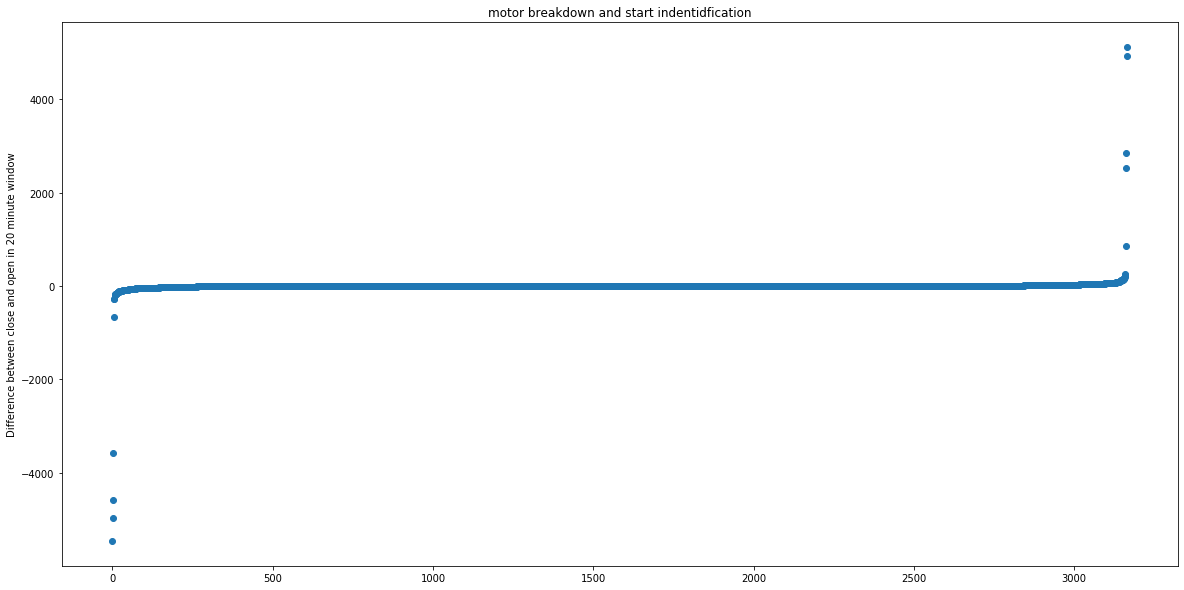

In [234]:
df=get_labels(df)


In the graph, the four dots with extremely low values denote breakdowns and extremely high values denotes the motor start. We will create flags for all '5min' entries falling under these dots.


##### In order to identify most important sensor (feature):
We will create our model on the data which corrosponds to "motor on" mode and flag "breakdown" as ones according to our above definition 

In [178]:
filtered_df=df[(df['on']==1) | (df['breakdown_flag']==1)]

In [218]:
cols=list(n_df.columns)
cols.append('breakdown_flag')
train=filtered_df[cols]

In [388]:
X, y=train.drop(['Timestamp', 'breakdown_flag'],axis=1).dropna(axis=1, how='any'), train['breakdown_flag']
print("Total number of events are {} and non_events  are {}".format(y.sum(), len(y)-y.sum()))

Total number of events are 20 and non_events  are 5530


Due the less event rate we will use SMOTE to balance our dataset a bit.

In [212]:
from  imblearn.over_sampling import SMOTE

In [213]:
oversample = SMOTE(sampling_strategy=0.02)
X, y = oversample.fit_resample(X, y)

In [221]:
from sklearn.model_selection import train_test_split

In [224]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)

In [226]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score


# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=42)

forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

#### Precision and recall of our classifier seems fair enough 

In [228]:
precision_score(y_test, forest.predict(X_test) ), recall_score(y_test, forest.predict(X_test) )

(0.8571428571428571, 0.75)

With this classifier we can know about the feature importance

Feature ranking:
1. feature 0 (0.168079)
2. feature 9 (0.137970)
3. feature 4 (0.132399)
4. feature 12 (0.099306)
5. feature 7 (0.093611)
6. feature 1 (0.067960)
7. feature 5 (0.065500)
8. feature 8 (0.064331)
9. feature 11 (0.063962)
10. feature 2 (0.050866)
11. feature 6 (0.029780)
12. feature 10 (0.013978)
13. feature 3 (0.012258)


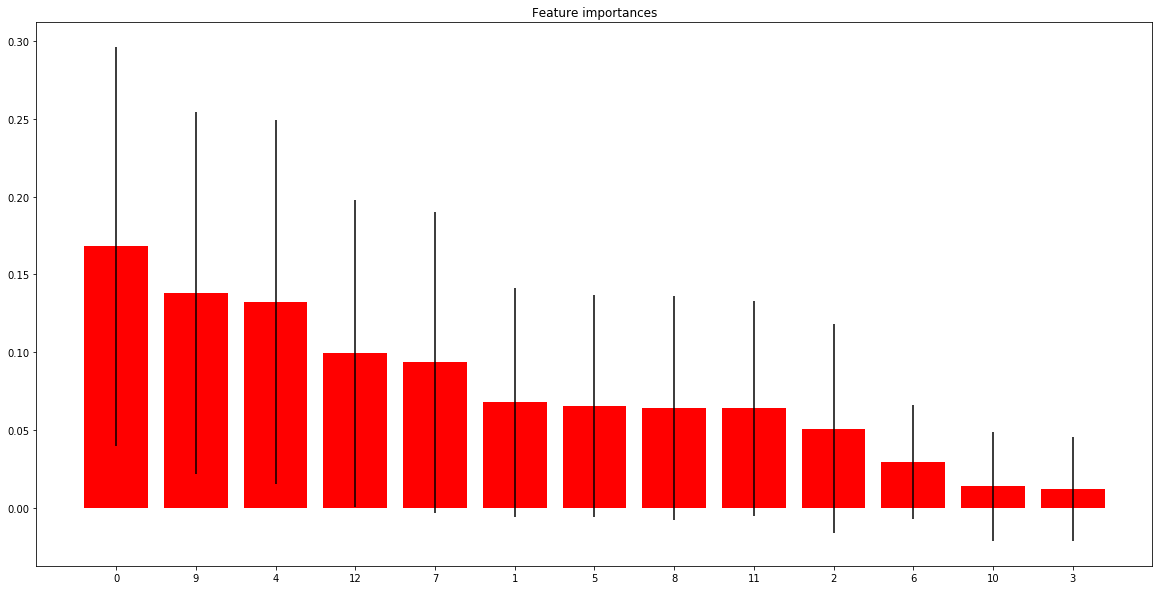

In [229]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### FUTURE SCOPE AND IMPROVEMENTS:
1. We can build our models on more robust definitions about the different phases of the motor. 
2. We can build RNN models from sratch or use ensemble of other outlier detection algorithms and do a better comparision of different results. 
3. Make more relevant features to feed into the model with better business understanding and domain knowledge. 
4. Identification of specific sequences and labelling for building supervised sequence models. 


- Editor:: Ishitwa Viranchi